In [1]:
%matplotlib inline
import sys
sys.path.append("../")

import cv2
from tqdm import tqdm
import matplotlib as mpl
import matplotlib.pyplot as plt
import pylab
import numpy as np
import scipy.io as scio

import torch
from PIL import Image

import quat_math as qm
from generic_pose.utils import to_np, to_var


import warnings; warnings.simplefilter('ignore')
pylab.rcParams['figure.figsize'] = 20, 12

In [2]:
def imshowCV(img, axis = False, show = True):
    if not axis:
        plt.axis('off')
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    if(show):
        plt.show()
    
def imshow(img, axis = False, colorbar = False, show = True):
    if not axis:
        plt.axis('off')
    plt.imshow(img)
    if(colorbar):
        plt.colorbar()
    if(show):
        plt.show()
    
def torch2Img(img, show = True):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    disp_img = to_np(img)
    if len(disp_img.shape) == 4:
        disp_img = disp_img[0]
    disp_img = disp_img.transpose((1,2,0))
    disp_img = disp_img * std + mean
    return disp_img
    
#from generic_pose.utils.image_preprocessing import unprocessImages
def imshowTorch(img, axis = False, show = True):
    if not axis:
        plt.axis('off')
    disp_img = torch2Img(img)
    plt.imshow(disp_img.astype(np.uint8))
    #plt.imshow(unprocessImages(img)[0])
    if(show):
        plt.show()

def plotImageScatter(img, choose, show = True):
    coords = np.unravel_index(choose, img.shape[:2])    
    plt.axis('off')
    plt.imshow(img.astype(np.uint8))    
    plt.scatter(coords[1], coords[0], 50)
    #plt.colorbar()
    if(show):
        plt.show()

In [3]:
dataset_root = '/home/bokorn/data/ycb/debug/'
model_checkpoint = '/home/bokorn/Downloads/dfus_weights/pose_model_train_split_34_0.025648579025031315.pth'
test_filenames = '{0}/images_sets/train_split.txt'.format(dataset_root)


In [4]:
from dense_fusion.evaluate import DenseFusionEstimator, preprocessData
#from dense_fusion.data_processing import preprocessPoseCNNMetaData

num_points = 1000
num_obj = 21
df_estimator = DenseFusionEstimator(num_points, num_obj, model_checkpoint)

In [5]:
from object_pose_utils.datasets.pose_dataset import OutputTypes as otypes

output_format = [otypes.OBJECT_LABEL,
                 otypes.TRANSFORM_MATRIX,
                 otypes.IMAGE_CROPPED,
                 otypes.DEPTH_POINTS_MASKED_AND_INDEXES]

object_list = [14]
mode = "train_syn"

from object_pose_utils.datasets.ycb_dataset import YcbDataset as YCBDataset
from object_pose_utils.datasets.ycb_dataset import YcbImagePreprocessor

with open('{0}/image_sets/classes.txt'.format(dataset_root)) as f:                                    
    classes = f.read().split()
classes.insert(0, '__background__')
dataset = YCBDataset(dataset_root, mode=mode, 
                     object_list = object_list, 
                     output_data = output_format, 
                     preprocessor = YcbImagePreprocessor,
                     image_size = [640, 480], num_points=1000)

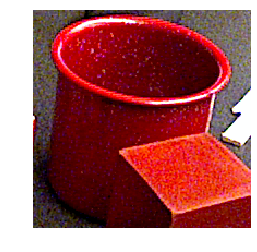

In [6]:
idx = 8
data = dataset.__getitem__(idx)
#for data in dataloader:
#    break
obj, mat, im, pts, chs = data
meta_data = dataset.getMetaData(idx, mask=True, bbox=True, camera_matrix=True)
imshowTorch(im)

In [7]:
from dense_fusion.evaluate_likelihood import getYCBClassData, getYCBGroundtruth

with open(test_filenames) as f:
    file_list = f.read().split()
class_list, model_points = getYCBClassData(dataset_root)
data_prefix = '{0}/{1}'.format(dataset_root, file_list[0])

img = Image.open('{}-color.png'.format(data_prefix))
depth = np.array(Image.open('{}-depth.png'.format(data_prefix)))
pose_meta = scio.loadmat('{}-meta.mat'.format(data_prefix))
posecnn_meta = scio.loadmat('{}-posecnn.mat'.format(data_prefix))
object_classes = set(pose_meta['cls_indexes'].flat) & \
                    set(posecnn_meta['rois'][:,1:2].flatten().astype(int))
cls_idx = list(object_classes)[0]
obj_idx = np.nonzero(posecnn_meta['rois'][:,1].astype(int) == cls_idx)[0][0]
mask, bbox, object_label = preprocessPoseCNNMetaData(posecnn_meta, obj_idx)

q_gt, _ = getYCBGroundtruth(pose_meta, posecnn_meta, obj_idx)
q_gt = torch.Tensor(q_gt).unsqueeze(0)
if(torch.cuda.is_available()):
    q_gt = q_gt.cuda()


FileNotFoundError: [Errno 2] No such file or directory: '/home/bokorn/data/ycb/debug//images_sets/train_split.txt'

In [ ]:
from object_pose_utils.utils.grid_interpolation import BinghamInterpolation

pred_r, pred_t, pred_c = df_estimator(img, depth, mask, bbox, object_label, return_all = True)[3:6]
pred_r = pred_r[0,:,[1,2,3,0]]
pred_c.shape
bingham_interp = BinghamInterpolation(vertices = to_np(pred_r), 
                                      values = pred_c, 
                                      sigma=10)

bingham_interp(q_gt)

In [ ]:
from dense_fusion.evaluate_likelihood import evaluateYCBEvery

evaluateYCBEvery(df_estimator, data_prefix, 10)

In [ ]:
mean_likelihood = 0
n = 0
for v in likelihoods.values():
    mean_likelihood += np.sum(v)
    n += len(v)
mean_likelihood /= n

print(mean_likelihood)

In [ ]:
import scipy.io as sio
eta_values = sio.loadmat('../object_pose_utils/src/object_pose_utils/utils/bingham_normalization.mat')
print(eta_values)

In [ ]:
from dense_fusion.evaluate_likelihood import subRandomSigmaSearch

with open(test_filenames) as f:
    file_list = f.read().split()
subRandomSigmaSearch(df_estimator, dataset_root, file_list, 
                     sigma_lims = [0, 30],
                     num_samples=100)

In [ ]:
from object_pose_utils.utils.pose_processing import getGaussianKernal

print(torch.as_tensor([q_center, q_center1]).shape)
print(torch.Tensor(q).shape)
sigma = np.pi/9

getGaussianKernal(torch.Tensor(q[0:3]).float(), 
                  torch.as_tensor([q_center, q_center1]).float(), 
                  sigma=sigma)


In [ ]:
from object_pose_utils.utils import to_np
from object_pose_utils.utils.grid_interpolation import GaussianInterpolation, BinghamInterpolation
import numpy as np
import torch


q_center = np.random.randn(4)
q_center /= np.linalg.norm(q_center)

w = [1]

N = 100
q = np.random.randn(4,N)
q = (q / np.linalg.norm(q, axis=0)).T
#pbs = []
#pgs = []
#sigma_multipliers = np.linspace(1,100, 1000)
#sigma_multipliers = np.logspace(-2,2, 1000)
#for multi in sigma_multipliers:
sigma_gauss = np.pi/9
#sigma_bingham = sigma_gauss*2.8474391664672476
sigma_bingham = sigma_gauss


binghamInterp = BinghamInterpolation(vertices = [q_center], 
                                     values = torch.Tensor(w), 
                                     sigma=sigma_bingham)
p_bingham = to_np(binghamInterp(torch.Tensor(q).cuda()))

#print(p_bingham)
#pbs.append(p_bingham)

gaussianInterp = GaussianInterpolation(vertices = [q_center], 
                                       values = w, 
                                       sigma=sigma_gauss)



p_gauss = to_np(gaussianInterp(torch.Tensor(q).cuda()))
#print(p_gauss)
plt.plot(p_gauss, label = 'Gaussian')
plt.plot(p_bingham, label = 'Bingham')
plt.legend()
#pgs.append(p_gauss)
#plt.plot(sigma_multipliers, pbs, label = 'Bingham')
#plt.plot(sigma_multipliers, pgs, label = 'Gaussian')
#diff = np.log(np.array(pgs)/np.array(pbs))
#diff = np.abs(np.array(pgs)-np.array(pbs)) / np.array(pgs)
#print(np.nonzero(diff > 0)[0][0])
#plt.plot(sigma_multipliers, diff)
#plt.xscale('log')
plt.show()

In [ ]:
min_idx = np.argmin(diff, axis = 0)
min_val = np.min(diff, axis = 0)

min_idx = min_idx[np.bitwise_and(min_idx > 0, min_val < .5)]

print(max(sigma_multipliers[min_idx]))
plt.hist(sigma_multipliers[min_idx], 10)
plt.show()